In [2]:
# Acá van las librerías que vamos a ocupar :)
import csv                                   # Para leer archivo
import numpy as np                           # Útil para procesos matemáticos 
import math
from datetime import date as dt              # Para trabajar con fechas y diferencias de fechas 
from dateutil import relativedelta as rd
import matplotlib.pyplot as plt              # Plotting 
import json                                  # Formato para guardar diccionario de nodos en .txt

## Proyecto Tarea 2

El objetivo de este proyecto es ver el valor de una opción call en todo momento usando el formalismo de la aproximación al modelo Binomial. 

Para este ejemplo, usamos las acciones de Tesla, tomando como precio inicial el closing del 10/04/2023, mientras que el precio de ejercicio será $E=0,9S_0$, con fecha de vencimiento el 10/10/2023. La tasa de interes será sin riesgo y de 10%, mientras que los periodos $\delta t=1/$días habiles. 

a) 
Lo primero que debemos hacer es calcular la deriva historica anual, mediante el uso de la siguiente formula, vista en clases: 

$$\mu=\frac{1}{M\delta t}\sum_{i=1}^N R_i= \frac{1}{N\delta t}\sum_{i=1}^N \frac{S_{i+1}-S_{i}}{S_{i}},$$

donde M es el numero de periodos o días habiles, $R_i$ es el retorno de cada día y $S_i$ será el valor de la acción en el día $i$. Por otro lado, la desviación estandar historica estaría dada por la siguiente expresión, támbien vista en clases: 

$$ \sigma=\sqrt{\frac{1}{(M-1)\delta t}\sum_{i=1}^N (R_i-\bar{R})^2} $$


Donde $\bar{R}=\mu\sqrt{\delta t}$ corresponde a la media del retorno. Realizemos, entonces, el cálculo de estas variables para los datos de TSLA entregados. 

In [3]:
# Primero debemos cargar los archivos 
with open('TSLA.csv', 'r', encoding='utf-8') as file:
    data = csv.DictReader(file)
    data = [row for row in data] 

# data: Lista de entradas en el .csv en formato de diccionario, por ejemplo...
print('Ejemplo d in data: {}'.format(data[0]))

# Fecha a objeto date_time
def str_to_dt(date): 
    date = date.split('-')
    return dt(int(date[0]), int(date[1]), int(date[2]))

# Función que checkea si la fecha esta dentro del rango deseado:
def date_check(date, lim_date='2023-04-10'):
    date = date.split('-')
    date = dt(int(date[0]), int(date[1]), int(date[2]))
    lim_date = lim_date.split('-')
    lim_date = dt(int(lim_date[0]), int(lim_date[1]), int(lim_date[2]))
    t_delta = rd.relativedelta(lim_date, date)
    d_months = t_delta.months + t_delta.years*12
    d_days = (lim_date - date).days
    if d_months < 6: return (True, d_days)
    elif d_months == 6 and t_delta.days == 0: return (True, d_days)
    else: return (False, d_days)
    
# Filtramos los datos correspondientes a los 6 meses más recientes (desde la última entrada en el .csv).    
data = [d for d in data if date_check(d['Date'])[0]]

# Fecha desde la que trabajamos: 
print('Primera entrada considerada: {}'.format(data[0]))

Ejemplo d in data: {'Date': '2022-04-11', 'Open': '326.799988', 'High': '336.156677', 'Low': '324.880005', 'Close': '325.309998', 'Adj Close': '325.309998', 'Volume': '59357100'}
Primera entrada considerada: {'Date': '2022-10-10', 'Open': '223.929993', 'High': '226.990005', 'Low': '218.360001', 'Close': '222.960007', 'Adj Close': '222.960007', 'Volume': '67925000'}


In [4]:
Delta_t = 1/len(data)
def mu_hist(data):
    work_days = len(data)
    delta_t = Delta_t
    sum_result = 0
    for d in data: sum_result += (float(d['Close']) - float(d['Open']))/float(d['Open'])
    return sum_result/(work_days*delta_t)

def sigma_hist(data):
    mu_h = mu_hist(data)
    work_days = len(data)
    delta_t = Delta_t
    sum_result = 0
    for d in data: sum_result += ((float(d['Close']) - float(d['Open']))/float(d['Open']) - mu_h*np.sqrt(delta_t))**2
    return np.sqrt(sum_result/((work_days-1)*delta_t))    

mu_h = mu_hist(data)
sigma_h = sigma_hist(data)
print('mu historico de TSLA últimos 6 meses: {}'.format(mu_hist(data)))   
print('sigma historico de TSLA últimos 6 meses: {}'.format(sigma_hist(data)))  

mu historico de TSLA últimos 6 meses: -0.031493477273816156
sigma historico de TSLA últimos 6 meses: 0.41855949342195076


b) En este ítem nos piden determinar los precios para cada nodo hasta la fecha de ejercicio. Para esto, el método binomial nos indica que, dado un día $i$ con valor $S_i$, el dia siguiente $i+1$ tendrá uno de dos valores; $uS_i$ o $vS_i$, donde:

$$ u = 1+\sigma\sqrt{\delta t},\\ v= 1-\sigma\sqrt{\delta t}.$$

Al iterar esto a lo largo del periodo solicitado, obtendremos un arbol binario de resultados que desplegaremos a continuación, junto a los valores correspondientes para $u$ y $v$.

Para esta aplicación en pos de ahorrar memoria no generare los nodos de valor repetido para un mismo $t$, por lo que en su lugar tendremos un solo nodo de un valor determinado que comparte padres. 

In [4]:
u = 1+sigma_h*np.sqrt(Delta_t)
v = 1-sigma_h*np.sqrt(Delta_t)
print('u: {}'.format(u))
print('v: {}'.format(v))

u: 1.0374370991967743
v: 0.9625629008032257


In [5]:
# Valor Inicial
s0 = float(data[-1]['Close'])

# Función encargada de generar todos los puntos para cada día 
# SIN REPETIR VALORES EL MISMO DÍA
# Solo contamos los días laborales 
def bin_tree_points(f_inicio='2023-04-10', f_termino='2023-10-10', s0=s0, u=u, v=v):
    f_inicio = str_to_dt(f_inicio)
    f_termino = str_to_dt(f_termino)
    days = np.busday_count(f_inicio, f_termino)
    ts = np.arange(1, days, 1)
    
    outcomes = [[(0,s0)]]
    for t in ts:
        new_outcomes = []
        for k in range(0, t+1): new_outcomes.append((t,s0*(u**k)*(v**(t-k))))
        outcomes.append(new_outcomes)
    return outcomes
    
points = bin_tree_points()

In [10]:
# Esta función generaría el grapho entero, repitiendo valores
# Dejo adjunto el documento tree_data.txt donde genere todo hasta el 20'abo día hábil (de +-130)
# Después de eso el archivo pesa GBs y se reinicia mi PC xD
###
def bin_tree_graph(f_inicio='2023-04-10', f_termino='2023-10-10', s0=s0, u=u, v=v):
    f_inicio = str_to_dt(f_inicio)
    f_termino = str_to_dt(f_termino)
    days = np.busday_count(f_inicio, f_termino)
    days = 2 # Ejemplo Para no matar el computador, recomendación: no superar 20!
    ts = np.arange(1, days+1, 1)
    
    root = {0:{'id':0, 's':s0, 'time':0, 'father': None}}
    with open('tree_data.txt', 'w') as file:
            file.write(json.dumps(root))
    def recursive_builder(outcomes=root, recent_outcomes=root, time=0, last_id=0):
        # Paramos la función cuando hayamos generado todos los días 
        print('Progress: {}/{}'.format(time, days),end="\r")
        if time == days:
            return recent_outcomes
        # Generamos los nodos nuevos en t=t+1
        new_outcomes={}
        for ro in recent_outcomes.values(): 
            new_outcomes[last_id+1]={'id':last_id+1, 's':ro['s']*u, 'time':time+1, 'father': ro['id']}
            new_outcomes[last_id+2]={'id':last_id+2, 's':ro['s']*v, 'time':time+1, 'father': ro['id']}
            last_id += 2
        # Update nuestra base de datos
        with open('tree_data.txt', 'a') as file:
            file.write(json.dumps(new_outcomes))
        #outcomes.update(new_outcomes)
        # Volvemos a iterar
        return recursive_builder(outcomes=outcomes, recent_outcomes=new_outcomes, time=time+1, last_id=last_id)
    # Llamamos la función recursiva
    return recursive_builder()     
###

graph = bin_tree_graph()

Este último codigo es solo para demostrar que podría generar TODOS los nodos dado un PC con más RAM, aunque dado el contexto de este ejercicio no tiene sentido generar nodos con valor duplicado en el mismo día. Dicho esto, trabajare solo con los valores singulares de ahora en adelante, lo que no debería afectar nuestro outcome deseado al graficar. 

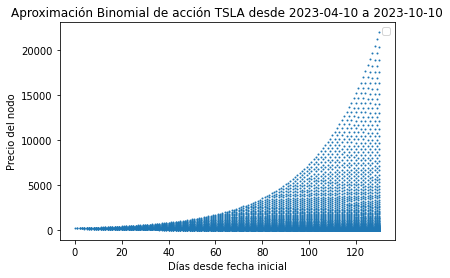

In [7]:
# Gráfiquemos en un scatter plot

x=[]
y=[]
for l in points:
    x += [p[0] for p in l]
    y += [p[1] for p in l]


fig, ax = plt.subplots()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)

ax.scatter(x,y, s=1)
ax.set_title('Aproximación Binomial de acción TSLA desde 2023-04-10 a 2023-10-10')
ax.set_ylabel('Precio del nodo')
ax.set_xlabel('Días desde fecha inicial')
plt.show()

Vemos como la acción de TSLA es muy volatíl en nuestra simulación, como nos indicaba el valor de $\sigma$ historico obtenido. Note como la curva superior indica que el valor de la acción sube con el tiempo. Esto nos ayudará entender el grafico del siguiente ítem. 

c) Recordando lo visto en clases, si ahora queremos calcular el valor de una opción call, el valor $V$ de una opción en $t$ vendría dado por

$$ V= \frac{1}{1+r\delta t}(pV^+ + (1-p)V^-),$$

donde los valores $V^+$ y $V^-$ corresponden a el posible valor mayor y menor de la acción al día siguiante, que calculamos en el item anterior. $p$ corresponde a la probabilidad ficcticia de un mundo sin riesgo, tal que 

$$p=\frac{1}{2}+\frac{r\sqrt{\delta t}}{2\sigma}.$$

Como en este caso queremos modelar una opción call, diremos que su valor será igual a 

$$ V(S,T)=\textit{max}(S-E,0),$$

donde el precio de ejercicio será $E=0,9S_0$ y la tasa de interes $r=0.1$ vienen dados por el enunciado, y $S$ será el valor de la acción en el día del ejercicio. Partiendo desde los ultimos nodos, podemos llegar al valor actual. 

In [8]:
f_inicio='2023-04-10' 
f_termino='2023-10-10'
f_inicio = str_to_dt(f_inicio)
f_termino = str_to_dt(f_termino)
days = np.busday_count(f_inicio, f_termino)
delta_t = 1/days

def inverse_proces_graph(end_nodes, delta_t=delta_t, sigma=sigma_h, r=0.1, E=0.9*s0):
    p = 0.5 + (r*np.sqrt(delta_t))/(2*sigma)
    
    # Función de valor para opción call
    def value(v_p, v_m, p=p, delta_t=delta_t, r=r, E=E): return np.max([(1/(1+r*delta_t))*(p*v_p+(1-p)*v_m)-E,0])
    
    # Función recursiva que arma los nodos para atras 
    def recursive_builder(nodes=[end_nodes], last_nodes=end_nodes):
        t = last_nodes[0][0]-1
        if t < 0: return nodes # Si llegamos al t<0, detenemos la recursión 
        new_nodes = [] # Vamos a generar todos los valores tomando en cuenta que los nodos intermedios tienen 2 padres
        for i in range(0, len(last_nodes)-1): 
            new_nodes.append((t, value(last_nodes[i+1][1],last_nodes[i][1])))
        nodes.append(new_nodes)
        return recursive_builder(nodes=nodes, last_nodes=new_nodes)
    
    return recursive_builder()
    
points_call = inverse_proces_graph(points[-1])

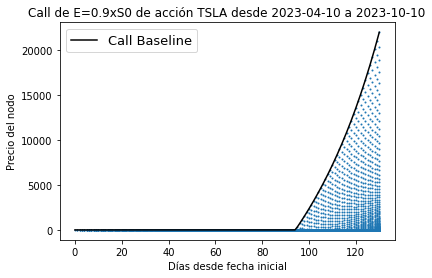

In [9]:
# Gráfiquemos en un scatter plot
x=[]
y=[]
x_baseline = []
y_baseline = [] 
for l in points_call:
    x += [p[0] for p in l]
    y += [p[1] for p in l]

    x_baseline += [l[-1][0]]
    y_baseline += [l[-1][1]] 


fig, ax = plt.subplots()
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels)

ax.scatter(x,y, s=1)
ax_call = ax.plot(x_baseline, y_baseline, color='black', label='Call Baseline')
ax.legend(handles=ax_call, prop={'size': 13})
ax.set_title('Call de E=0.9xS0 de acción TSLA desde 2023-04-10 a 2023-10-10')
ax.set_ylabel('Precio del nodo')
ax.set_xlabel('Días desde fecha inicial')
plt.show()

Podemos ver en el plot anterior como efectivamente los valores generados para cada nodo repsresentarían una opción call para el precio de ejercicio estipulado, ya que se ve como es nulo hasta $S=E$ y luego el limite superior se comporta como una diagonal, aumentando el valor de forma constante a medida que aumenta el tiempo o, más bién, a medida que aumenta el valor de la acción, como vimos en el grafíco anterior.